To start our project we firstly import some useful libraries, necessary for the next step of the code.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We import the dataset

In [7]:
sms = pd.read_csv('social_media_shares.csv')

We divide data in X and y, where X contains the independent variables, the regressor ones, that help us in predicting the response variable, that is stored in y.

In [8]:
X = sms.iloc[:,:-1]
y = sms.iloc[:,-1]

We proceed with the Explanatory data analysis (EDA) with visualization, to better understand the relationship between the variables and our dataset better.

We use these function to generate a descriptive statistics that summarize the central tendency, dispersion and shape of our dataset’s distribution.
We want also to see how our dataset is structured in terms of the type of information (numerical,categorical,empty values)

In [24]:
print(sms.describe())
print(sms.head())
print(sms.info())
print('Social media share dataset shape is', sms.shape)

       tokens_title  tokens_content  unique_tokens  non_stop_words  \
count  39644.000000    39644.000000   39644.000000    39644.000000   
mean      10.398749      546.514731       0.548216        0.996469   
std        2.114037      471.107508       3.520708        5.231231   
min        2.000000        0.000000       0.000000        0.000000   
25%        9.000000      246.000000       0.470870        1.000000   
50%       10.000000      409.000000       0.539226        1.000000   
75%       12.000000      716.000000       0.608696        1.000000   
max       23.000000     8474.000000     701.000000     1042.000000   

       non_stop_unique_tokens         hrefs     self_refs          imgs  \
count            39644.000000  39644.000000  39644.000000  39644.000000   
mean                 0.689175     10.883690      3.293638      4.544143   
std                  3.264816     11.332017      3.855141      8.309434   
min                  0.000000      0.000000      0.000000      0.0000

In addition, we are looking for the type of correlation between independent and dependent variable, so we utilize a scatter plot.

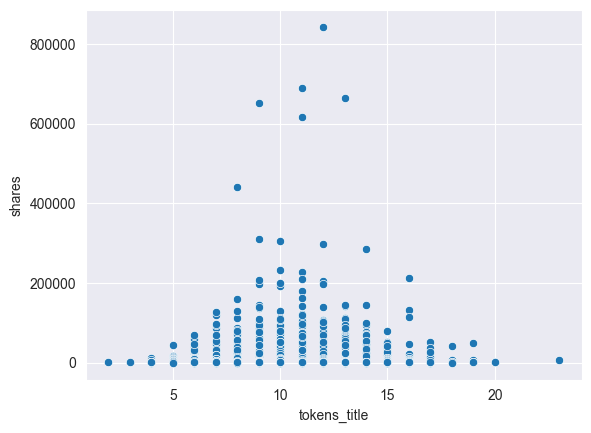

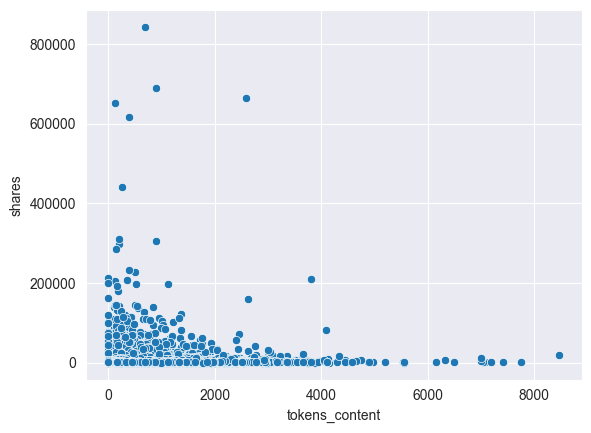

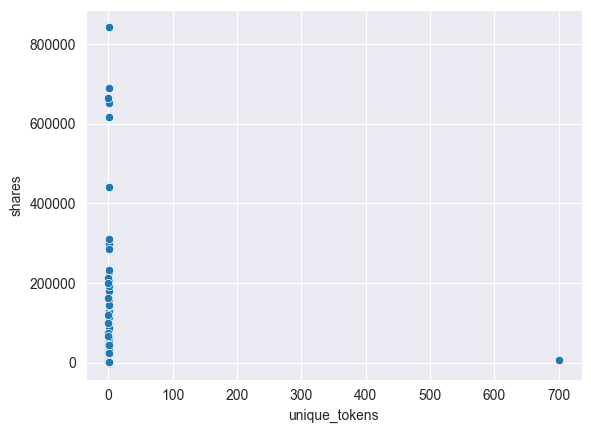

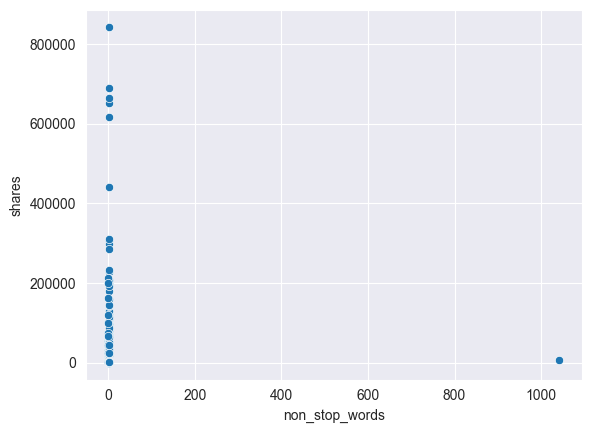

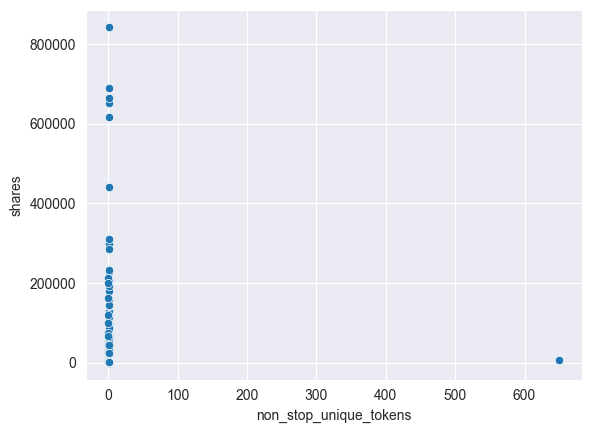

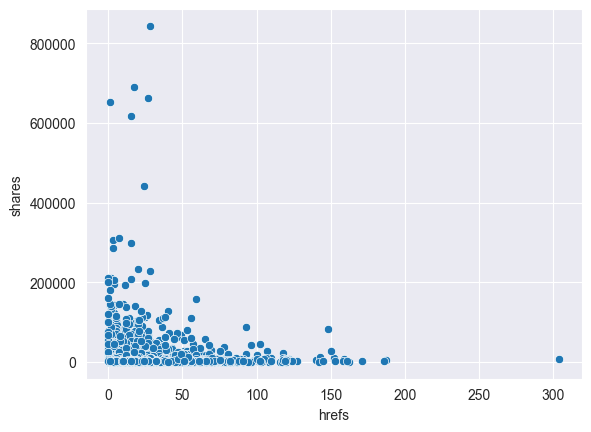

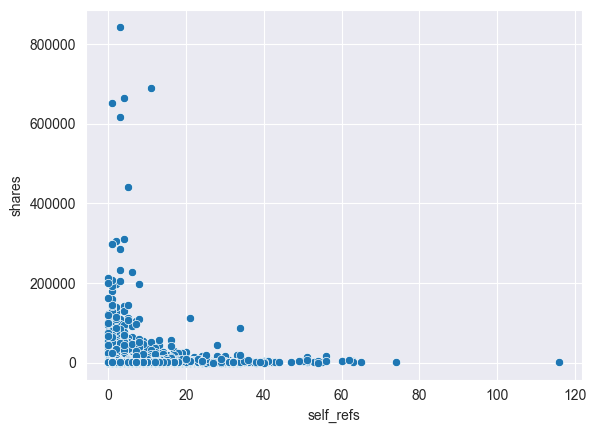

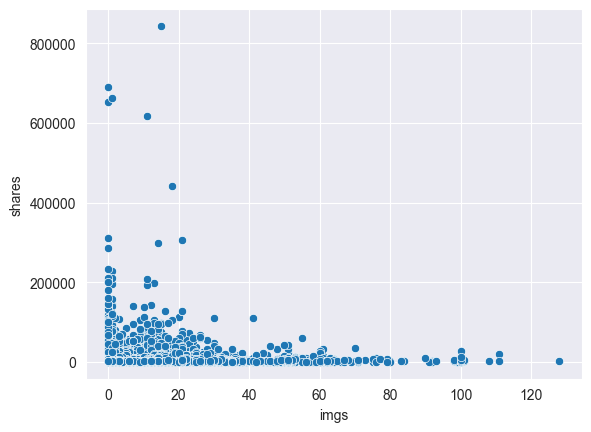

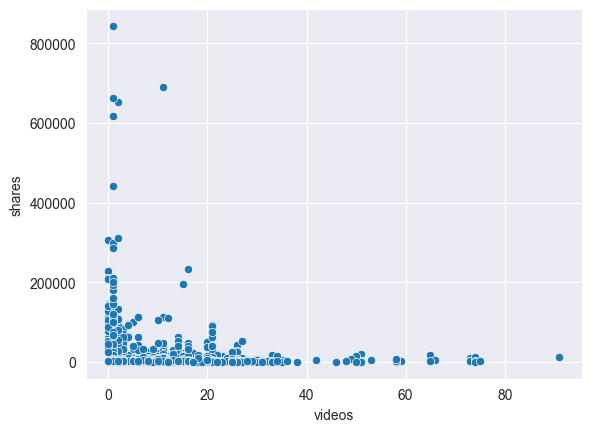

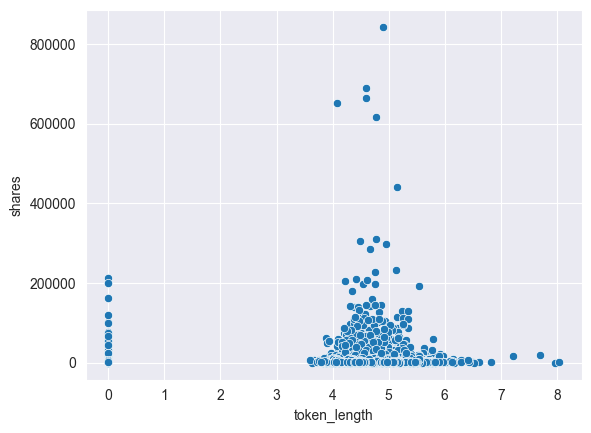

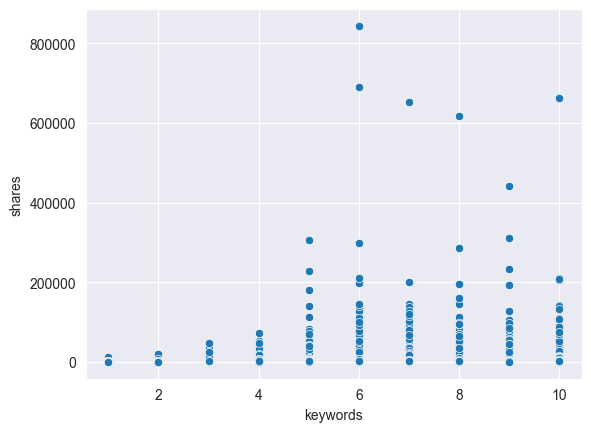

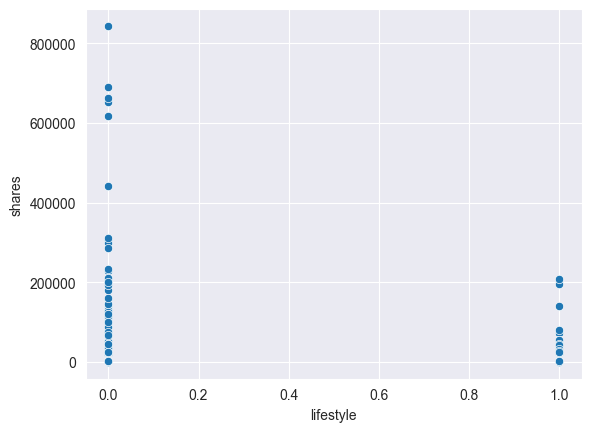

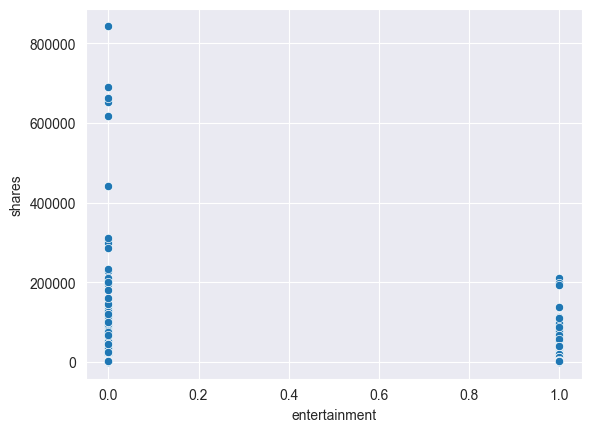

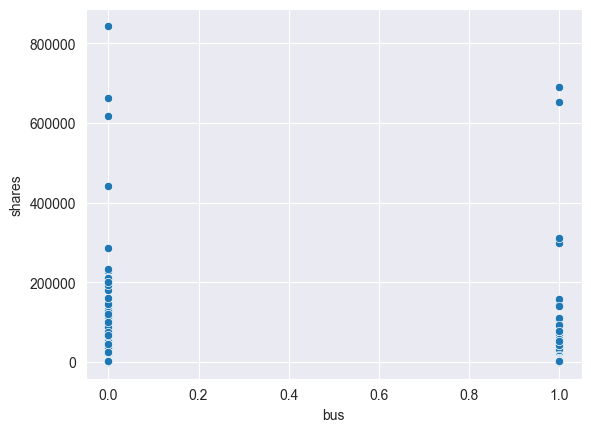

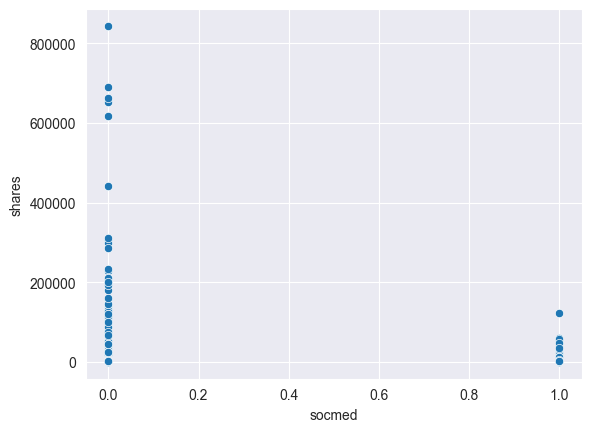

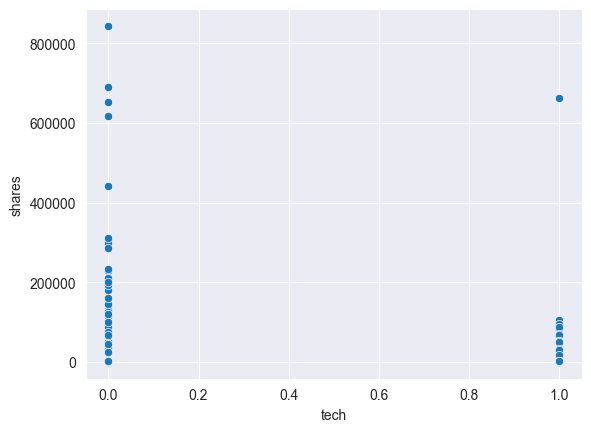

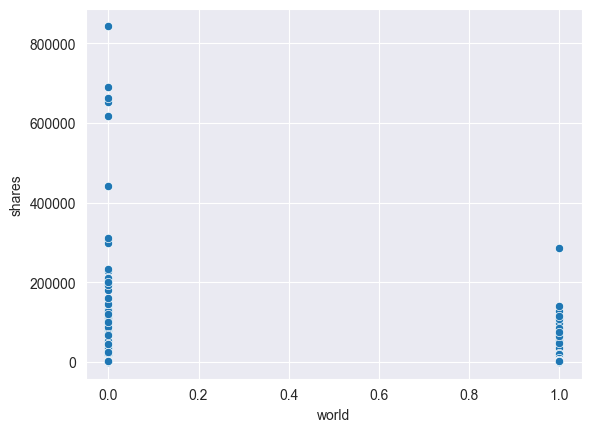

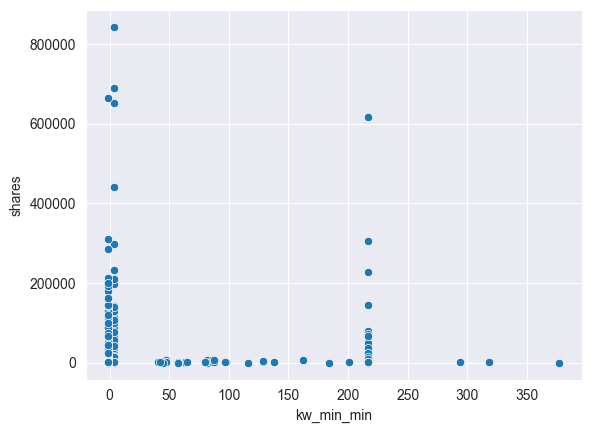

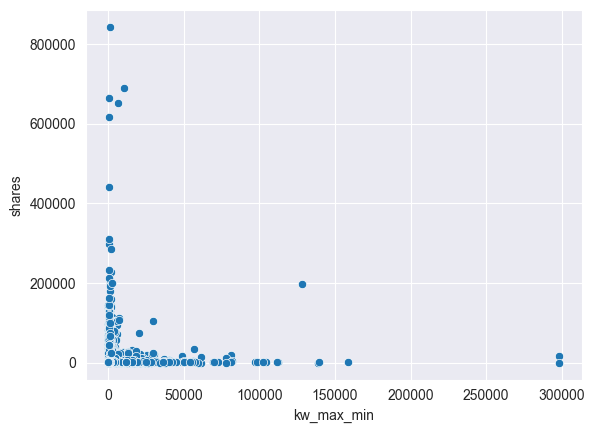

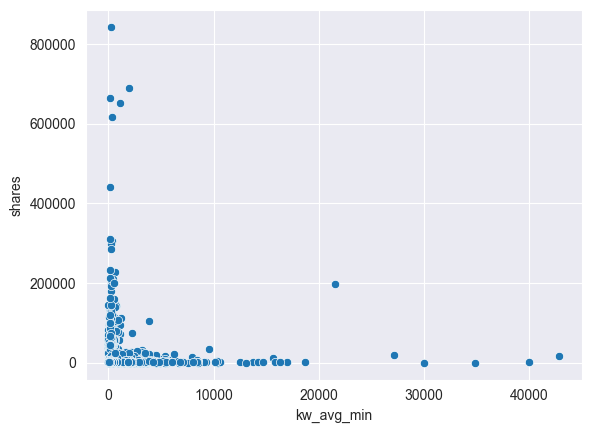

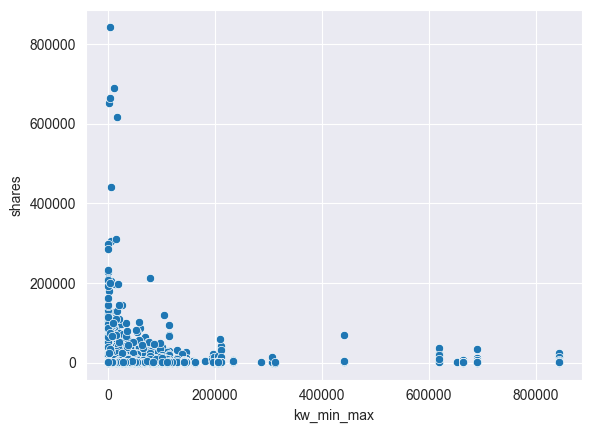

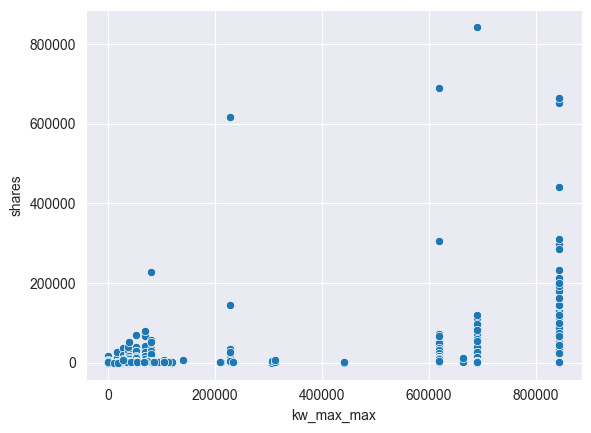

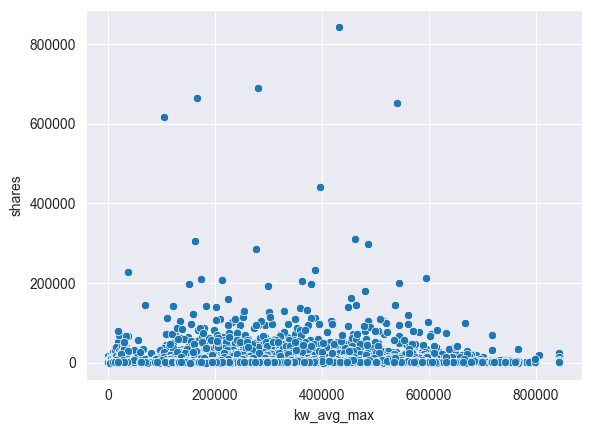

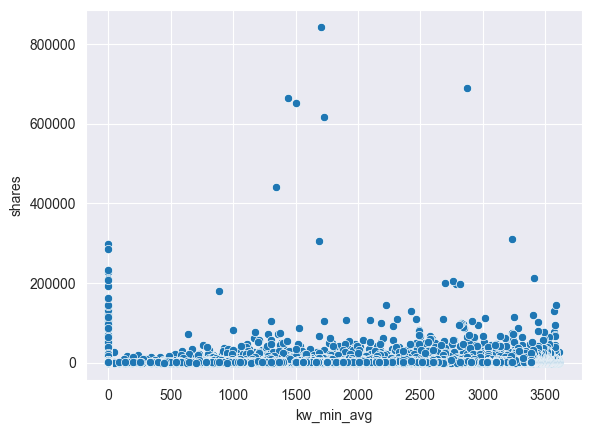

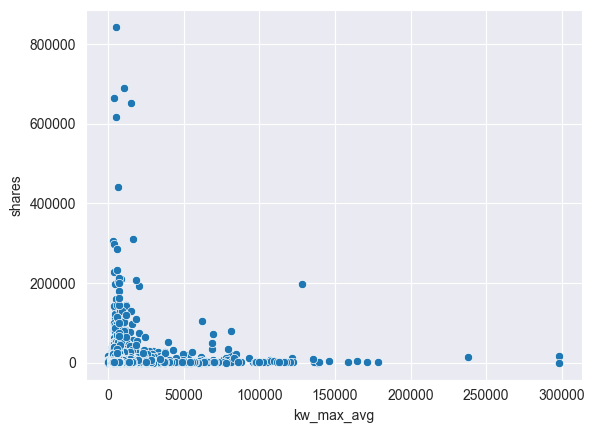

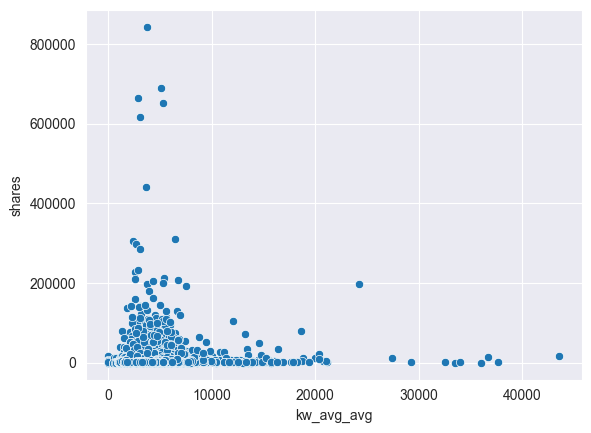

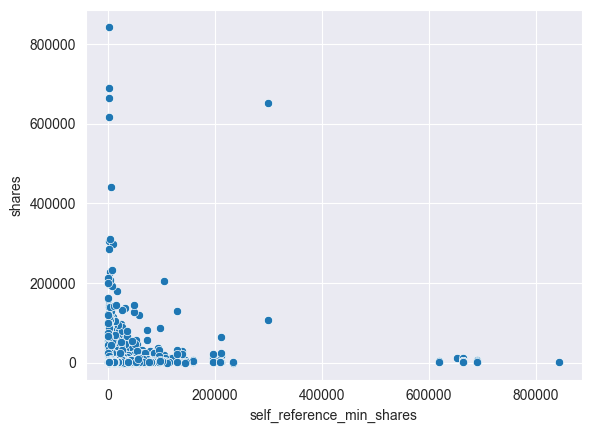

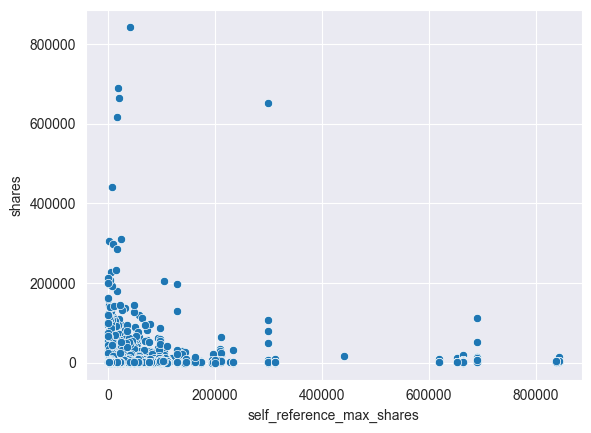

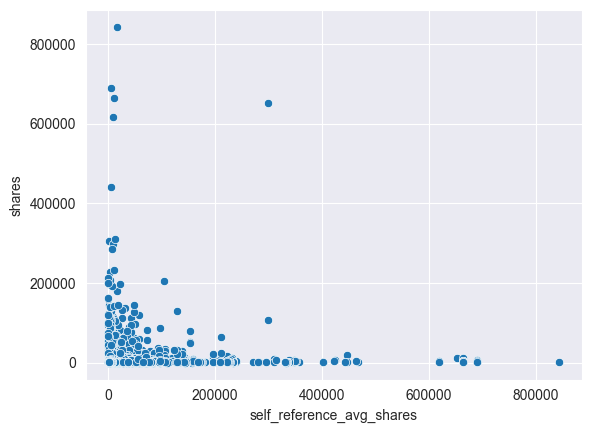

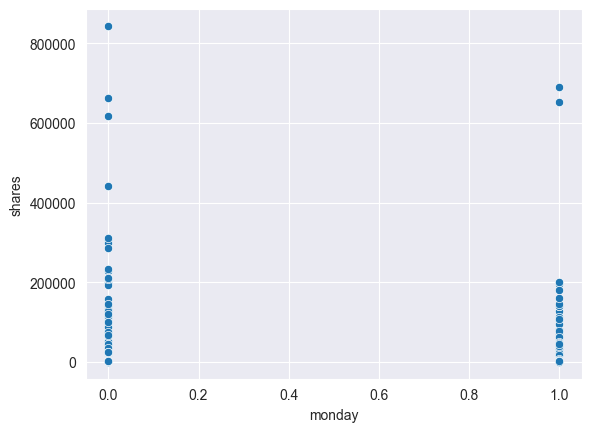

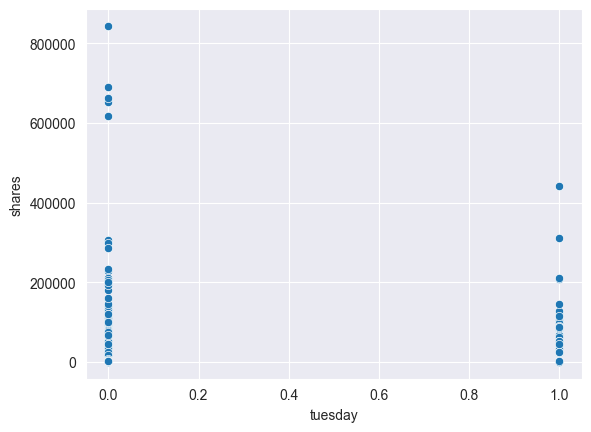

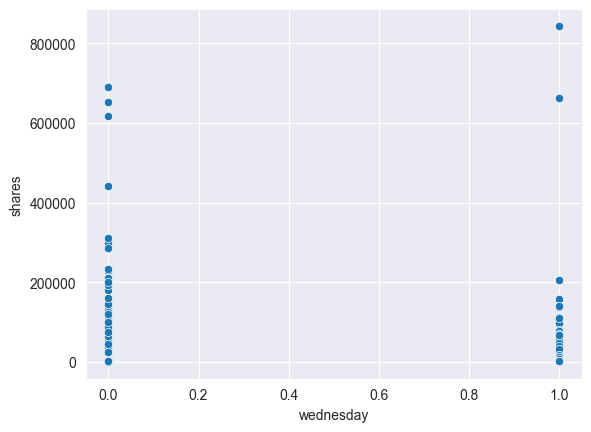

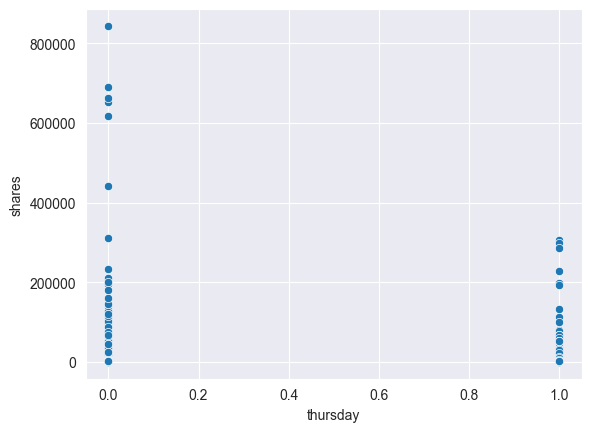

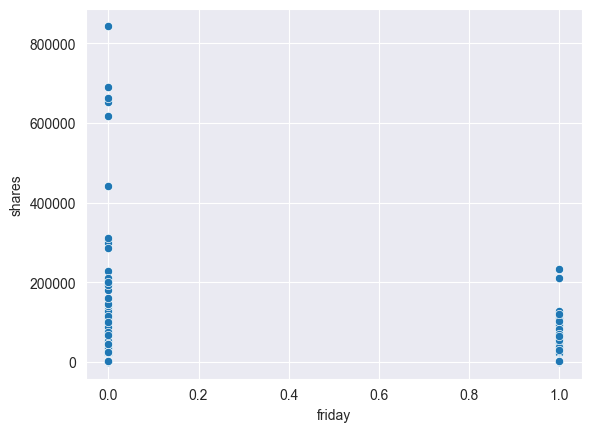

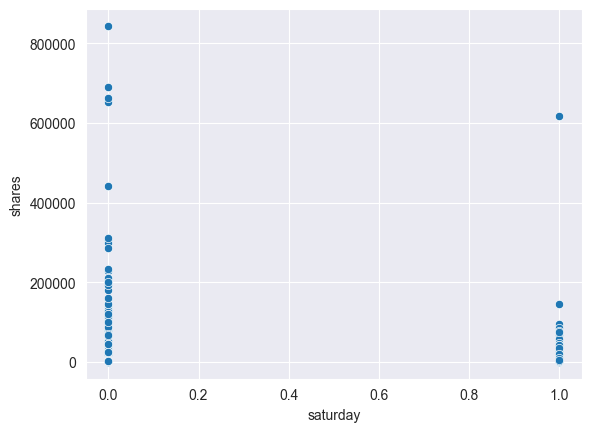

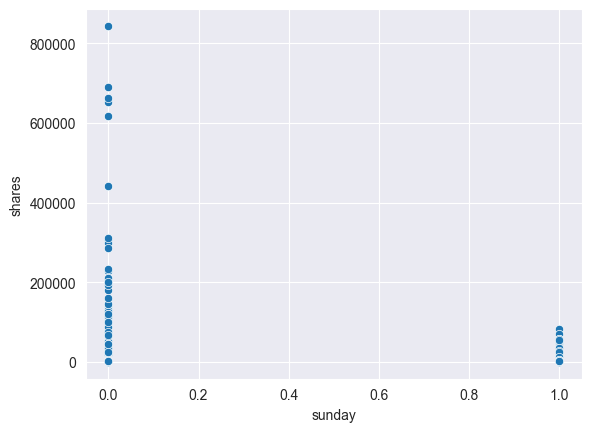

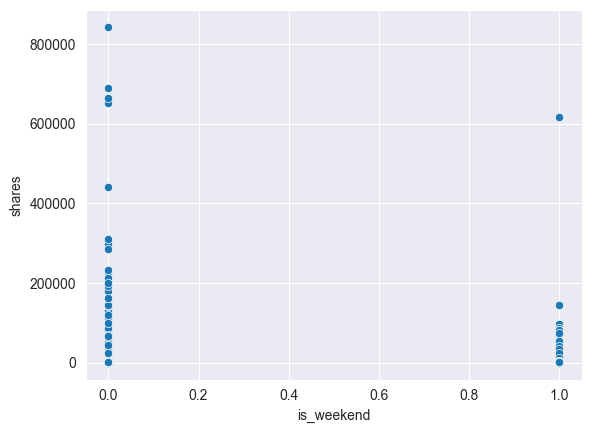

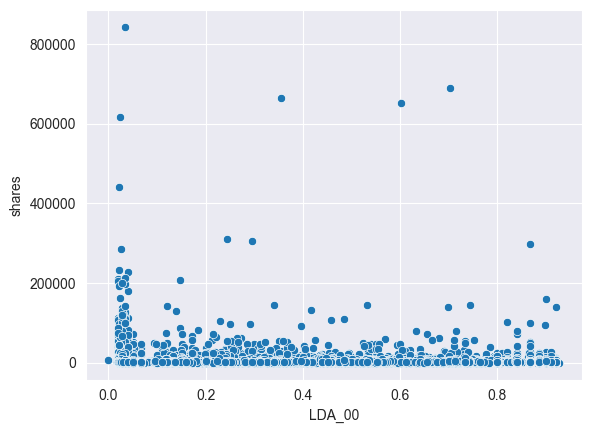

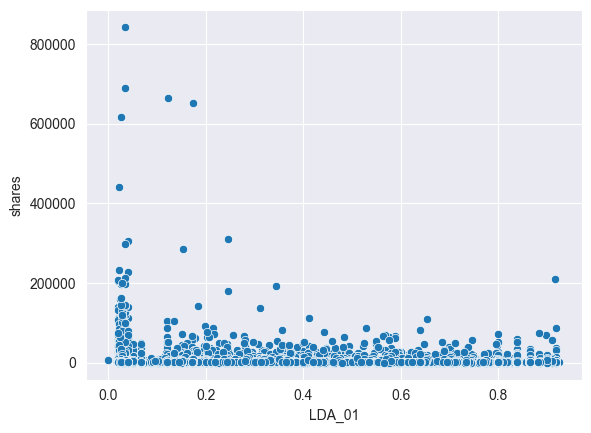

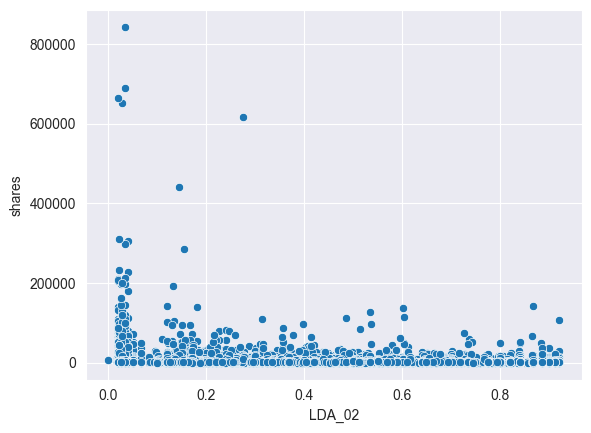

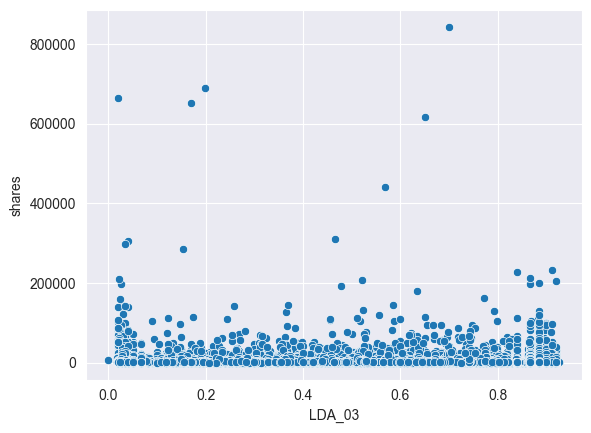

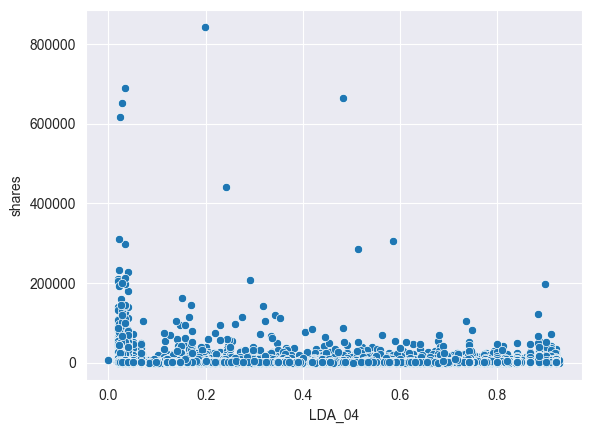

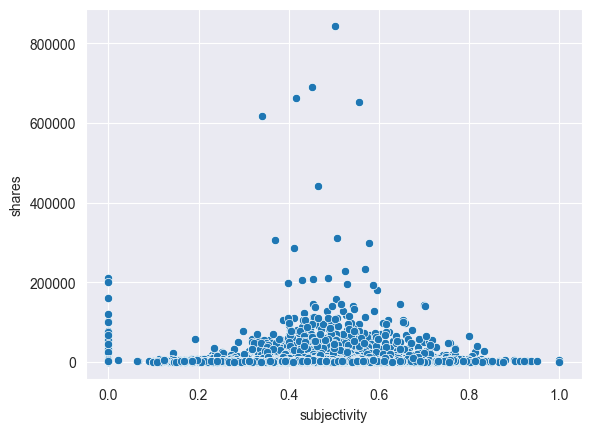

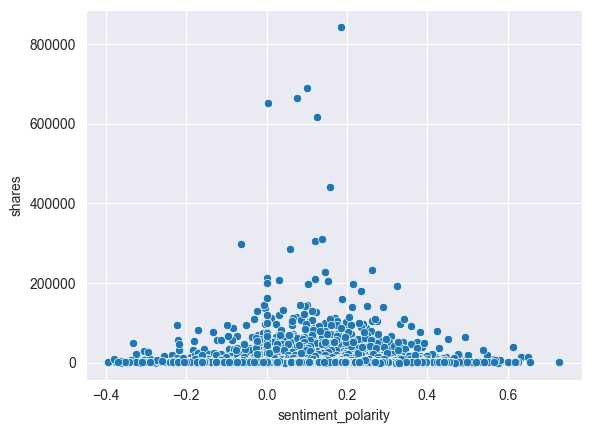

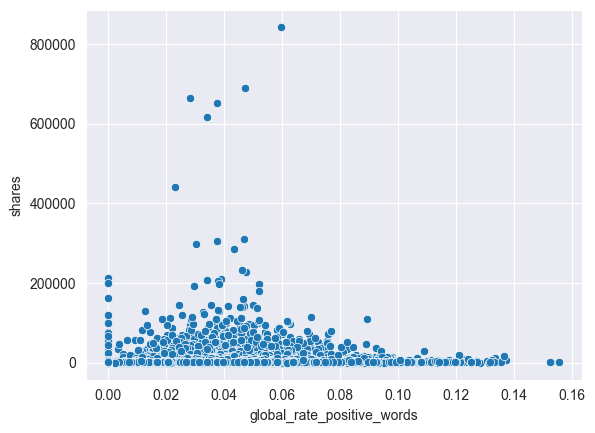

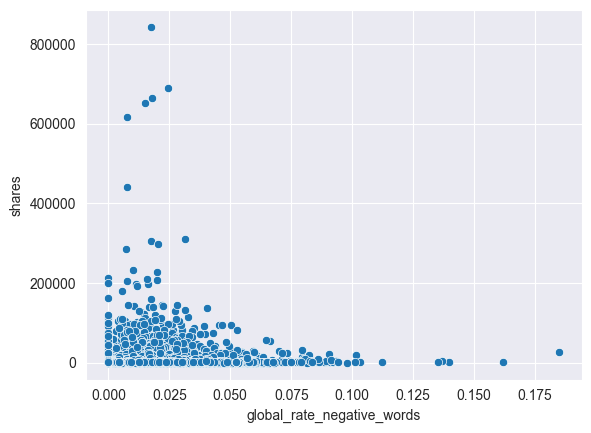

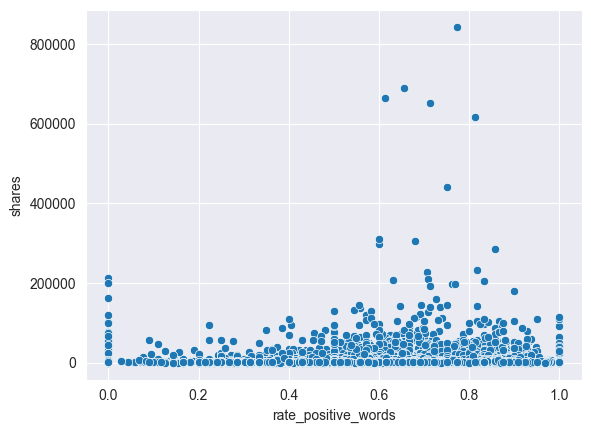

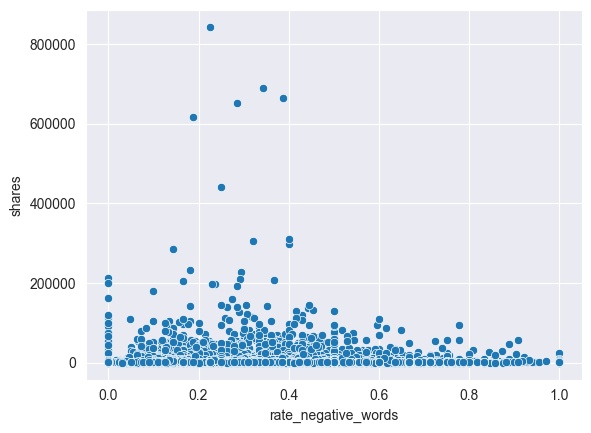

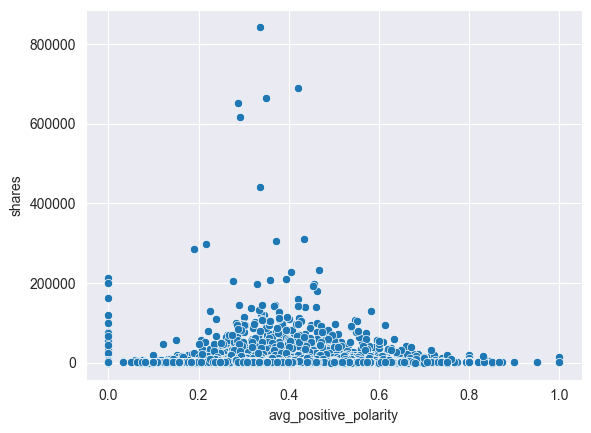

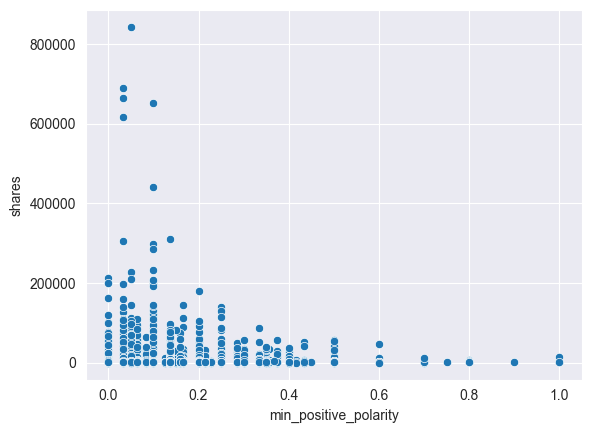

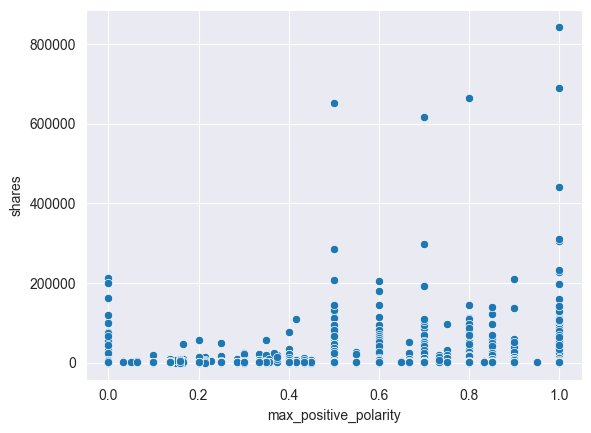

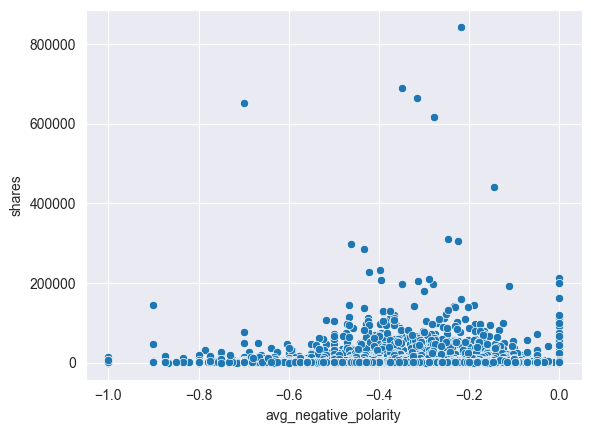

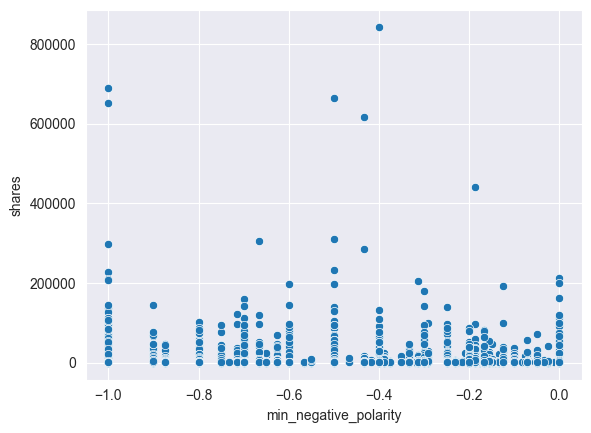

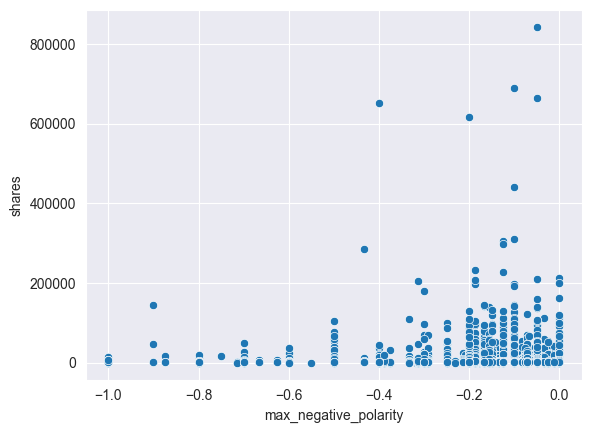

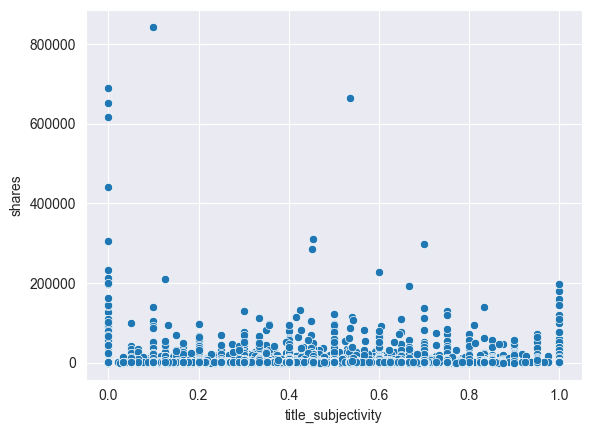

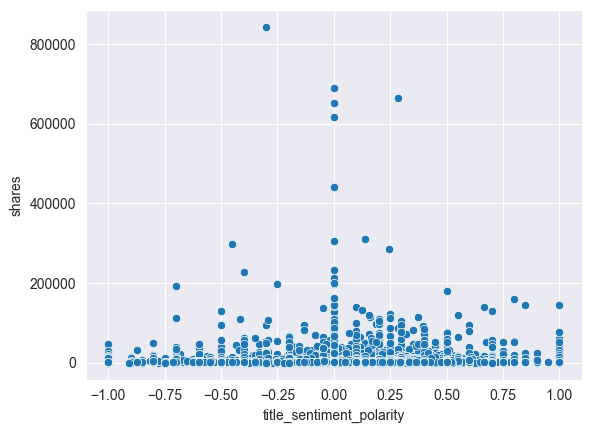

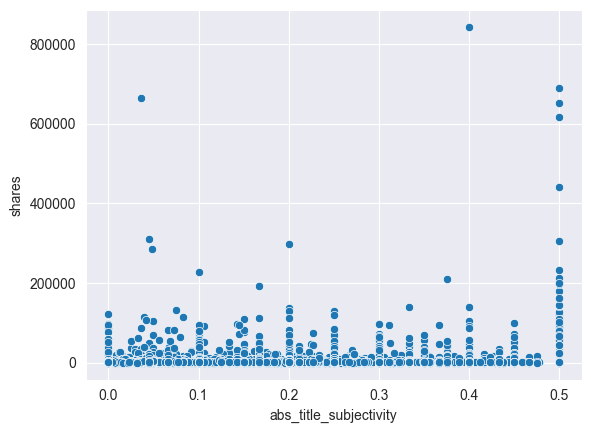

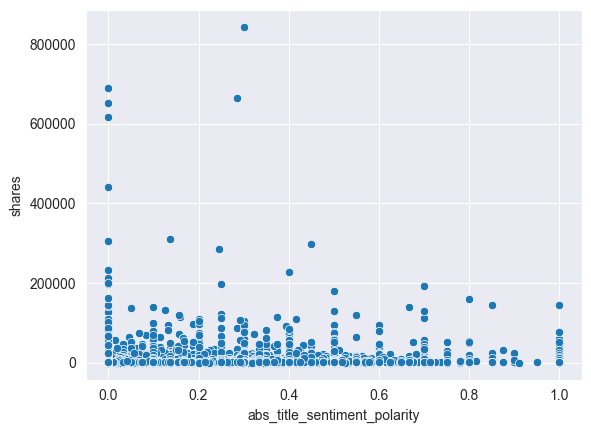

In [25]:
#We plot the relation between each regressor variable with the response variable "shares"
for col in X.columns:
  sns.scatterplot(data=sms,x=col,y='shares')
  plt.show()

We notice that there is not a linear correlation , but actually we can notice something else from these plots.In fact some plots are actually very similar, maybe because there is some correlation between the regressor variables, to check our assumption we plot the correlation matrix thanks to heat map.

<AxesSubplot: >

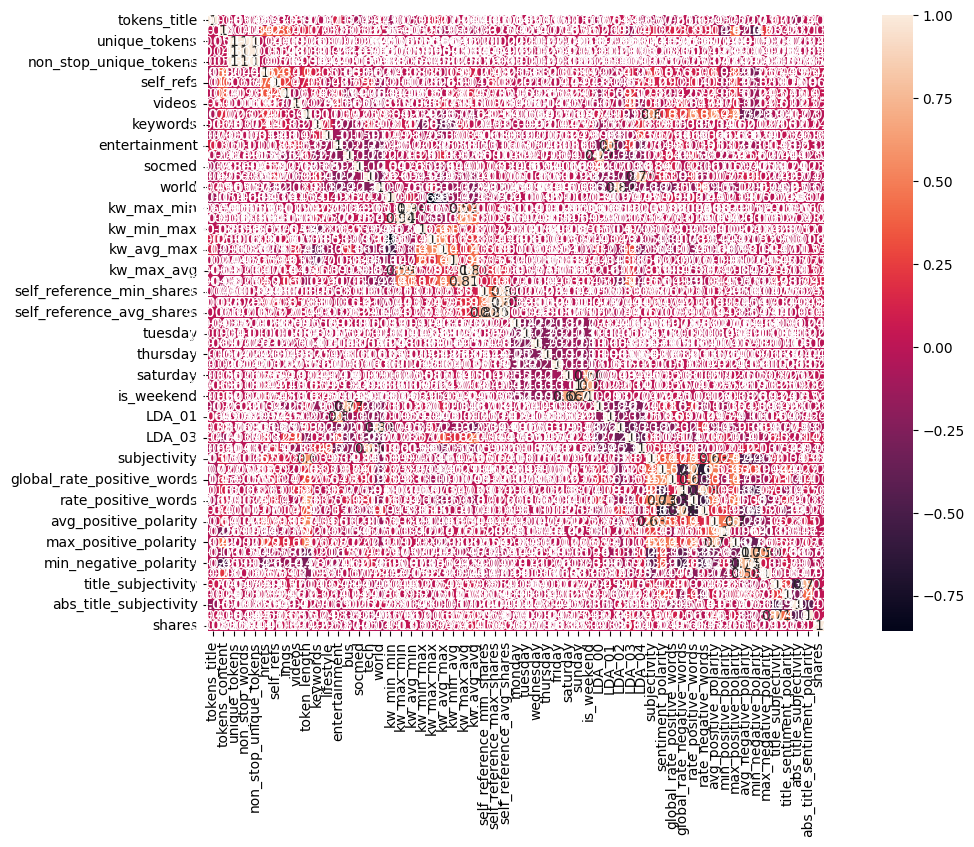

In [9]:
corr = sms.corr()
plt.figure(figsize = (15,8)) #To set the figure size
sns.heatmap(data=corr, square=True, annot=True, cbar=True)

We can notice that there is a high correlation (almost 0.99) between some variables, meaning that they give a similiary, almost the same information, so we remove and leave just one of the two.
We do this by selecting the upper triangle of the correlation matrix and remove the column having a correlation value greater than 0,95.

In [10]:
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))
to_drop = list([column for column in upper_tri.columns if any(upper_tri[column] > 0.95)])
X = X.drop(to_drop, axis=1)
# Let's check the new shape of our X matrix, containing our predictor variables:
# X is now with 56 variables because we removed the useless ones
print('New shape of the X matrix is ',X.shape)

New shape of the X matrix is  (39644, 56)


We now proceed in generating a training and test set.

In [11]:
#Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.27, random_state=42)
#Let's see the distribution of our data in the three splits
print("X:train shape: ", X_train.shape)
print("X:test shape: ", X_test.shape)

X:train shape:  (28940, 56)
X:test shape:  (10704, 56)


The next step is feature engineering, so we extract features from raw data, we check for categorical data to manage, remove outliers and so on.
As we saw from the function info we do not have categorical data but we have some variables with binary values (0,1) it look like one hot coder was already made it, so we will not scale them.
To avoid scaling the wrong columns we select their indexes and we decided to use Robust Scaler on all the other columns.
We used Robust Scalar because it's efficient both for scaling and for the removal of outliers.

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
#We do this in order to avoid scaling columns that have just a binary value (0,1),(as if the One Hot Encoder has done)
#We save the index of the columns to now which columns need to
index_k = X.columns.get_loc('keywords')
index_w = X.columns.get_loc('world')
index_m = X.columns.get_loc('monday')
index_is = X.columns.get_loc('is_weekend')
index_len = len(X.columns)

pipeline = ColumnTransformer([
  ('num', RobustScaler(), list(range(0, index_k + 1))),
  ('num1', RobustScaler(), list(range(index_w + 1, index_m))),
  ('num2', RobustScaler(), list(range(index_is, index_len))),

], remainder='passthrough')
sc = StandardScaler()
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

We know start implementing the regression models, we opt to implement Random Forest Regressor, SVR and Polynomial Regression.

First we want to create a function that gives us the best choices for the hyperparameters.
We proceed with a cross validation function in order to select the best combinations.

In [17]:
#GRID SEARCH with cross validation
#esplor the parameters to find the best combination
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

def best_scores_grid_search_df(reg):
    reg.cv_results_
    grid_table = pd.DataFrame(reg.cv_results_)
    colums_wanted = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    grid_table_rank = grid_table[colums_wanted].sort_values(by='rank_test_score', ascending=True)
    return grid_table_rank

To test all different combination of the hyperparameters we create a validation test, that is a small portion of the train test.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
print("X:train shape: ", X_train.shape)
print("X:valid shape: ", X_valid.shape)

X:train shape:  (23152, 56)
X:valid shape:  (5788, 56)


We start with SVM, let's find which combination of hyperparameters gives us the lower error .

In [32]:
from sklearn.svm import SVR
#create regressor object
svr =  SVR()
#select the hyperparameters
param_grid_svr = {'kernel': ['poly', 'rbf', 'sigmoid'], 'C': [np.power (10., a) for a in range(-1,3)]}
reg_svr = GridSearchCV(svr, param_grid_svr, cv=10,scoring='neg_mean_absolute_error')
reg_svr.fit(X_valid,y_valid)
# we print our greed to see the best combination
SVM_best_scores=best_scores_grid_search_df(reg_svr).head()
print(SVM_best_scores)


                             params  mean_test_score  std_test_score  \
10    {'C': 100.0, 'kernel': 'rbf'}     -2291.217325      445.490623   
7      {'C': 10.0, 'kernel': 'rbf'}     -2291.227772      446.070435   
4       {'C': 1.0, 'kernel': 'rbf'}     -2292.674991      446.697922   
5   {'C': 1.0, 'kernel': 'sigmoid'}     -2293.051441      446.822214   
3      {'C': 1.0, 'kernel': 'poly'}     -2293.142176      446.320423   

    rank_test_score  
10                1  
7                 2  
4                 3  
5                 4  
3                 5  


Now that we have found the optimal combination of the parameters we used them for defining the regressor that we will use after.

In [33]:
# we use these hyperparameters for the regression
svr_best_combination = SVM_best_scores.loc[SVM_best_scores['rank_test_score'] == 1]

svr_best_params = dict(svr_best_combination['params'])
for i in list(svr_best_params.values()):
    svr_best_params = i
print('The optimal combination of hyperparameter is',svr_best_params)
#our final regressor with the correct parameters is svr_regressor
svr_regression = SVR(kernel=svr_best_params['kernel'],C = svr_best_params['C'])




The optimal combination of hyperparameter is {'C': 100.0, 'kernel': 'rbf'}


Moving on to Random Forest.

In [34]:
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor_rf = RandomForestRegressor()
#select the hyperparameters
param_grid_rf ={'max_depth': range(4, 7),'n_estimators': (100, 300, 500)}
rfr_grid = GridSearchCV(regressor_rf,param_grid_rf,cv=10,scoring='neg_mean_absolute_error', verbose=0, n_jobs=-1)
rfr_grid_result = rfr_grid.fit(X_valid, y_valid)
# we print our greed to see the best combination
rfr_best_scores=best_scores_grid_search_df(rfr_grid).head()
print(rfr_best_scores)



                                  params  mean_test_score  std_test_score  \
2  {'max_depth': 4, 'n_estimators': 500}     -2898.160173      402.771453   
1  {'max_depth': 4, 'n_estimators': 300}     -2905.715080      409.971652   
0  {'max_depth': 4, 'n_estimators': 100}     -2911.653990      414.596944   
4  {'max_depth': 5, 'n_estimators': 300}     -2916.845544      400.659357   
5  {'max_depth': 5, 'n_estimators': 500}     -2918.499749      407.741486   

   rank_test_score  
2                1  
1                2  
0                3  
4                4  
5                5  


Same SVR's process for Random Forest

In [35]:
# we use these hyperparameters for the regression
rfr_best_combination = rfr_best_scores.loc[rfr_best_scores['rank_test_score'] == 1]
rfr_best_params = dict(rfr_best_combination['params'])
for i in list(rfr_best_params.values()):
    rfr_best_params = i
print('The optimal combination of hyperparameter is',rfr_best_params)
#our final regressor with the correct parameters is rfr
rfr = RandomForestRegressor(max_depth=rfr_best_params["max_depth"], n_estimators=rfr_best_params["n_estimators"],random_state=False, verbose=False)
#our final regressor with the correct parameters is rfr

The optimal combination of hyperparameter is {'max_depth': 4, 'n_estimators': 500}


We proceed find the best combination of hyperparameters for Polynomial Regression.

In this case we will create a for loop to simulate GridCV

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
degrees = [2,3] # Change degree "hyperparameter" here
for degree in degrees:
        poly_features = PolynomialFeatures(degree = degree)
        X_valid_poly = poly_features.fit_transform(X_valid)
        polynomial_regressor = LinearRegression()
        polynomial_regressor.fit(X_valid_poly, y_valid)
        scores = cross_val_score(polynomial_regressor, X_valid_poly, y_valid, cv=10, scoring= 'neg_mean_absolute_error' )
        print('with degree =', degree, 'mean :',scores.mean(), '+/-', 'std:',scores.std())


with degree = 2 mean : -6221.220769963644 +/- std: 1213.7707932294795
with degree = 3 mean : -19000.40478659184 +/- std: 9749.513970926368


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Same process for Polynomial Regression

In [15]:
#our final regressor with the correct parameters is poly_regressor
#We use degree = 2 since it gives us the best error
poly_regressor =PolynomialFeatures(degree=2)

Now we train our train data with our regression model with the optimal hyperparameters and then we measure it performance on the test set, checking the mean square error, absolute error and relative error.

Starting with th SVR

In [40]:
svr_regression.fit(X_train,y_train)
y_pred = svr_regression.predict(X_test)
print(mean_squared_error(y_test,y_pred,squared=False))
print(mean_absolute_error(y_test, y_pred))

11013.363209211355
2427.9992616525187


Subsequently, Random Forest

In [41]:
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(mean_squared_error(y_test,y_pred,squared=False))
print(mean_absolute_error(y_test, y_pred))

10739.47526604121
3053.8303148987284


Lastly Polynomial

In [ ]:
X_train = poly_regressor.fit_transform(X_train)
X_test = poly_regressor.transform(X_test)
#include bias parameter
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('mean square error is:',mean_squared_error(y_test,y_pred,squared=False))
print('mean absolute error is:',mean_absolute_error(y_test, y_pred))

For the final task of the project we select a subset of the attributes (only the most relevant) and with it we train and test again our best model.
Since our best model is SVR we will try the subset of attributes only on it.

From our analysis the most relevant columns are:

● tokens_title: Number of words in the title
● tokens_content: Number of words in the content
● hrefs: Number of links
● imgs: Number of images
● videos: Number of videos
● lifestyle: Topic Lifestyle
● entertainment: Topic Entertainment
● bus: Topic Business
● socmed: Topic Social Media
● tech: Topic Tech
● world: Topic World
● self_reference_min_shares: Min. shares of referenced articles in Mashable
● self_reference_max_shares: Max. shares of referenced articles in Mashable
● self_reference_avg_shares: Avg. shares of referenced articles in Mashable
● global_sentiment_polarity: Text sentiment polarity
● global_rate_positive_words: Rate of positive words in the content
● global_rate_negative_words: Rate of negative words in the content
● title_sentiment_polarity: Title polarity
● abs_title_subjectivity: Absolute subjectivity level
● abs_title_sentiment_polarity: Absolute polarity level

We create a new X test only with this regressor variables

In [ ]:
#We selected the indexes of the columns we are interested in
index1 = X.columns.get_loc('tokens_title')
index2 = X.columns.get_loc('tokens_content')
index3 = X.columns.get_loc('hrefs')
index4 = X.columns.get_loc('imgs')
index5 = X.columns.get_loc('videos')
index6 = X.columns.get_loc('lifestyle')
index7 = X.columns.get_loc('entertainment')
index8 = X.columns.get_loc('bus')
index9 = X.columns.get_loc('socmed')
index10 = X.columns.get_loc('tech')
index11 = X.columns.get_loc('world')
index12 = X.columns.get_loc('self_reference_min_shares')
index13 = X.columns.get_loc('self_reference_max_shares')
index14 = X.columns.get_loc('self_reference_avg_shares')
index15 = X.columns.get_loc('sentiment_polarity')
index16 = X.columns.get_loc('global_rate_positive_words')
index17 = X.columns.get_loc('global_rate_negative_words')
index18 = X.columns.get_loc('title_sentiment_polarity')
index19 = X.columns.get_loc('abs_title_subjectivity')
index20 = X.columns.get_loc('abs_title_sentiment_polarity')
index_len2 = len(X.columns)
#We create a list with the indexes
index_lst = [index1, index2, index3, index4, index5, index6, index7, index8, index9, index10, index11, index12, index13, index14, index15, index16, index17, index18, index19, index20]
#We make them the columns of our X
new_X= X.iloc[:, index_lst]
print(new_X)


We split in train and test the new X

In [ ]:
new_X_train,new_X_test,y_train,y_test= train_test_split(new_X,y,test_size=0.27,random_state=42)
print("new_X train shape: ",new_X_train.shape)
print("new_X test shape: ",new_X_test.shape)

We scale the new X

In [ ]:
index_len2 = len(new_X.columns)
pipeline = ColumnTransformer([
    ('num',RobustScaler(),list(range(0,index5+1))),
    ('num1',RobustScaler(),list(range(index12, index_len2))),
],remainder='passthrough')
new_X_train = pipeline.fit_transform(new_X_train)
new_X_test = pipeline.transform(new_X_test)

We can final try our best model on the  new X train:

In [ ]:
svr_regression.fit(new_X_train,y_train)
y_pred = svr_regression.predict(new_X_test)
print(mean_squared_error(y_valid,y_pred,squared=False))
print(mean_absolute_error(y_valid, y_pred))


Not that bad...scritto solo per risolvere issue